**Team Members:** Ethan Flores, Hayden Dinh, Adrian Apsay, Zander Vilaysane, Hieu Pham, Sadrac Santacruz

**Link to our dataset:** https://www.kaggle.com/datasets/kaggleashwin/vehicle-type-recognition

# Milestone 2: Data Exploration & Initial Preprocessing

In [136]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
from PIL import Image


Number of Classes: 4
Total number of Images: 400


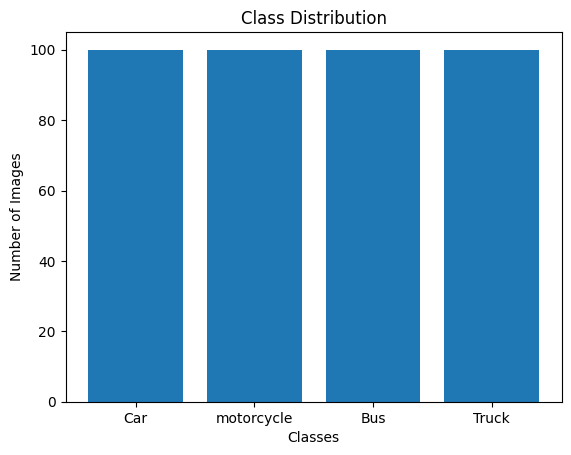

In [137]:
# Plot example classes of the image
image_dir = "Dataset"
image_classes = os.listdir(image_dir)

num_classes = len(image_classes)
num_images = sum(len(os.listdir(os.path.join(image_dir, cls))) for cls in image_classes)

print(f"Number of Classes: {num_classes}")
print(f"Total number of Images: {num_images}")

class_distribution = {cls: len(os.listdir(os.path.join(image_dir, cls))) for cls in image_classes}
plt.bar(class_distribution.keys(), class_distribution.values())
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()

As we see here, we have an even distribution of images within each folder for all classes

In [138]:
image_paths = []
folder_path = 'Dataset'

output_dct = {}
for vehicle in ['Bus', 'Car', 'motorcycle', 'Truck']:
    vehicle_folder = os.path.join(folder_path, vehicle)
    image_dimensions = []

    for img in os.listdir(vehicle_folder):
        img_path = os.path.join(vehicle_folder, img)

        with Image.open(img_path) as img:
            width, height = img.size
            image_dimensions.append((width, height))

    output_dct[vehicle] = image_dimensions

dimension_df = pd.DataFrame(output_dct)

In [139]:
for col in dimension_df.columns:
    num_unique = dimension_df[col].nunique()
    print(f'Number of unique image dimensions for {col}: {num_unique}')

Number of unique image dimensions for Bus: 82
Number of unique image dimensions for Car: 71
Number of unique image dimensions for motorcycle: 74
Number of unique image dimensions for Truck: 78


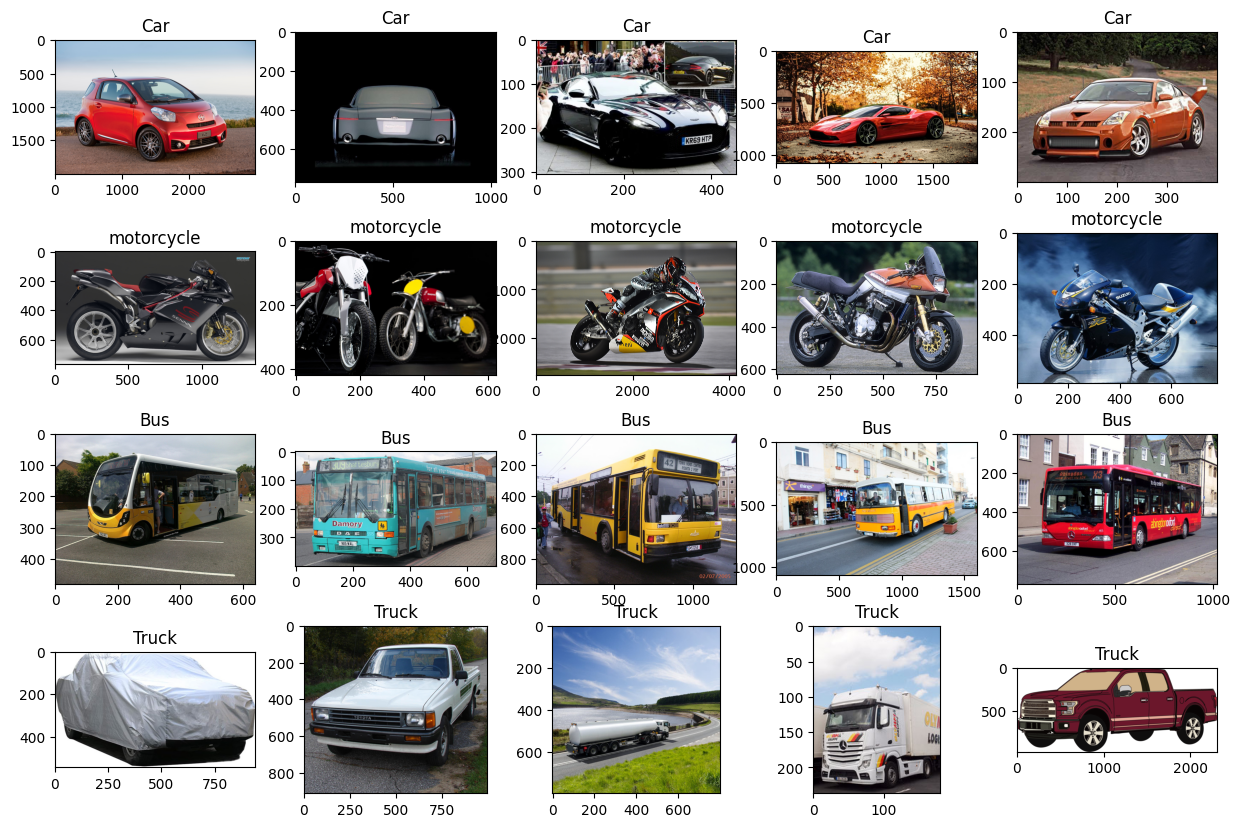

In [140]:
# example images for each class
image_dir = "Dataset"
image_classes = os.listdir(image_dir)
def display_samples(image_dir, num_samples=5):
    plt.figure(figsize=(15, 10))
    for cls in image_classes:
        sample_images = np.random.choice(os.listdir(os.path.join(image_dir, cls)), num_samples, replace=False)
        # print(sample_images)
        for i, img_name in enumerate(sample_images):
            img_path = os.path.join(image_dir, cls, img_name)
            img = Image.open(img_path)
            plt.subplot(len(image_classes), num_samples, i + 1 + image_classes.index(cls) * num_samples)
            plt.imshow(img)
            plt.title(cls)
    plt.show()

display_samples(image_dir)

As we can see when we plotted example images for each class above, a lot of them have different dimensions, in terms of sizing. In our preprocessing step, we are going to have to standardize the sizing of each image.

In [141]:
image_classes

['Car', 'motorcycle', 'Bus', 'Truck']

# Milestone 3: Pre-Processing & Baseline Model

Below, we are scaling, grayscaling, and rotating our images for preprocessing and data augmentation (as there aren't a lot of images per class, with all being capped at 100 per class).

In [142]:
import random
from random import sample

# function we define to display augmented data later
def display_sample_images(images, labels, num_samples=5, is_grayscale=False):
    sampled_images = sample(list(zip(images, labels)), num_samples)

    plt.figure(figsize=(15, 10))
    for i, img_and_label in enumerate(sampled_images):
        img = img_and_label[0]
        label = img_and_label[1]
        plt.subplot(1, num_samples, i + 1)
        if is_grayscale:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.show()

### Image Scaling

In [143]:
target_size = (256, 256)

scaled_images = []
scaled_labels = []

for cls in image_classes:
    folder_path = os.path.join(image_dir, cls)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        with Image.open(img_path) as img:
            scaled_img = img.resize(target_size)
            scaled_images.append(scaled_img)
            scaled_labels.append(cls)

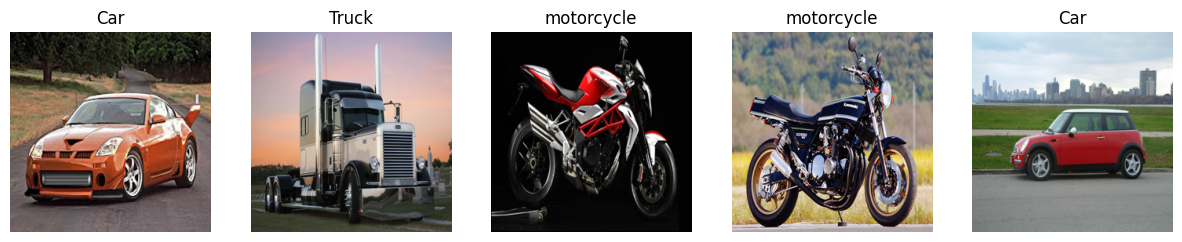

In [144]:
display_sample_images(scaled_images, scaled_labels)

### Grayscaling (the scaled images)

In [145]:
grayscale_images = []
grayscale_labels = []
for i in range(len(scaled_images)):
    grayscaled_img = scaled_images[i].convert('L')
    grayscale_images.append(grayscaled_img)
    grayscale_labels.append(scaled_labels[i])

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [146]:
scaled_labels == grayscale_labels

True

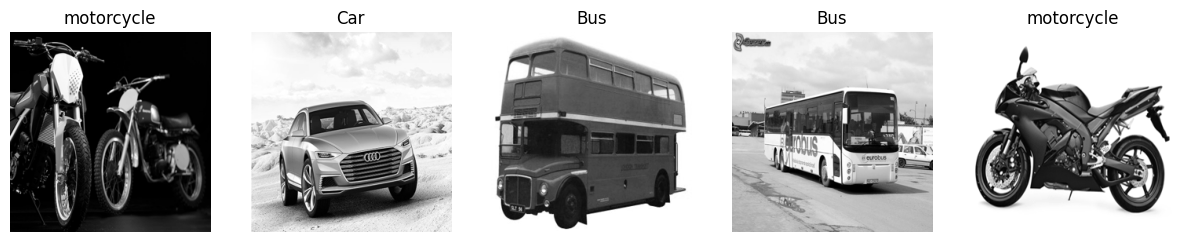

In [147]:
display_sample_images(grayscale_images, grayscale_labels, is_grayscale=True)

### Rotating Images (both non-grayscale and grayscale)
*note*: it's not realistic seeing a car image at an angle past 90 degrees (anything past 90 will result in a car being upside down), so the data will vary from angles 15, 30, 45, 60, 75.

In [86]:
angles = [15, 30, 45, 60, 75]
rotated_images = []
rotated_labels = []

# non grayscaled images for rotation
for i in range(len(scaled_images)):
    angle = np.random.choice(angles)
    rotated_img = scaled_images[i].rotate(angle)
    rotated_images.append(rotated_img)
    rotated_labels.append(scaled_labels[i])

# grayscaled images for rotation
for i in range(len(grayscale_images)):
    angle = np.random.choice(angles)
    rotated_grayscale_img = grayscale_images[i].rotate(angle)
    rotated_images.append(rotated_grayscale_img)
    rotated_labels.append(grayscale_labels[i])

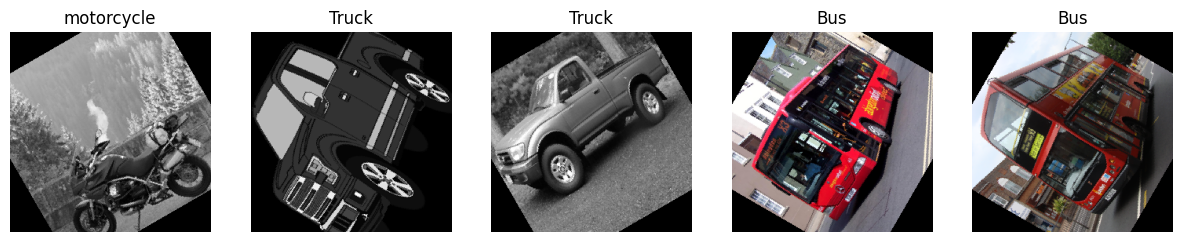

In [151]:
display_sample_images(rotated_images, rotated_labels, is_grayscale=True)

# Horizontally Flipping Images (non-grayscale and grayscale)
*note*: it's not realistic to see vehicles flipped upside down, so we're only flipping horizontally for our data augmentation.

In [152]:
flipped_images = []
flipped_labels = []

# non-grayscale
for i in range(len(scaled_images)):
    flipped_img = scaled_images[i].transpose(Image.FLIP_LEFT_RIGHT)
    flipped_images.append(flipped_img)
    flipped_labels.append(scaled_labels[i])

# grayscale
for i in range(len(grayscale_images)):
    flipped_grayscale_img = grayscale_images[i].transpose(Image.FLIP_LEFT_RIGHT)
    flipped_images.append(flipped_grayscale_img)
    flipped_labels.append(grayscale_labels[i])

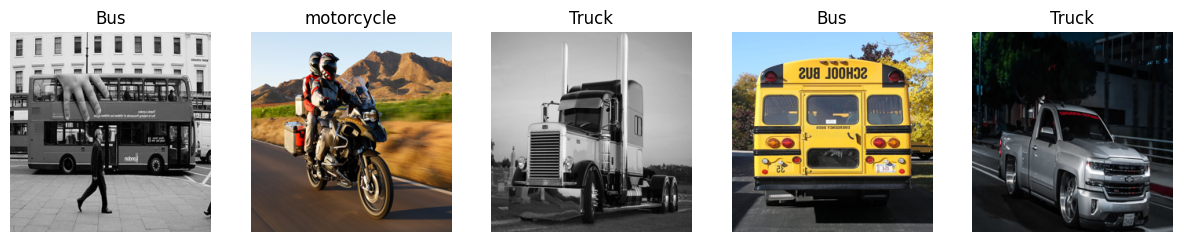

In [166]:
display_sample_images(flipped_images, flipped_labels, is_grayscale=True)